In [12]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
plt.ioff()
from cycler import cycler
import matplotlib.patches as mpatches
import seaborn as sns
import arviz as az
import scipy.stats as stats
import ROOT as r
import time
import ctypes
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=22
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')
%jsroot on

In [16]:
diagnostics_df=pd.read_csv("./diagnostics.csv",index_col=0)
sigma_df=pd.read_csv('./sigma.csv',index_col=0)
diagnostics_df1=pd.read_csv("./diagnostics_1.csv",index_col=0)
sigma_df1=pd.read_csv('./sigma_1.csv',index_col=0)
sigma_df=sigma_df.join(sigma_df1)
diagnostics_df=diagnostics_df.join(diagnostics_df1)

In [18]:
sigma_df

,toybin0000,toybin0001,toybin0002,toybin0003,toybin0004,toybin0005,toybin0006,toybin0007,toybin0008,toybin0009,...,toybin9990,toybin9991,toybin9992,toybin9993,toybin9994,toybin9995,toybin9996,toybin9997,toybin9998,toybin9999
0,0.360872,0.157471,0.399535,0.359232,0.045215,0.593074,0.116676,0.585016,0.444513,0.345688,...,0.397076,0.238349,0.239683,0.373095,0.041542,0.289273,0.185409,0.231186,0.425516,0.315653
1,0.415323,0.181994,0.367870,0.483443,-0.012639,0.239567,-0.088756,0.538212,0.099990,0.302664,...,0.363556,0.409687,0.361726,0.364450,0.164975,0.386008,0.309472,0.022813,0.351409,0.441754
2,0.476971,0.192912,0.365099,0.222839,0.091339,0.229557,-0.088756,0.576043,0.173054,0.294227,...,0.307136,0.411647,0.296056,0.497874,0.164975,0.290951,0.395906,0.062991,0.293593,0.466043
3,0.579798,0.343464,0.495066,0.189321,0.182541,0.229557,0.158755,0.586515,0.276672,0.304440,...,0.279766,0.364564,0.312055,0.495564,0.058792,0.074503,0.354974,0.267958,0.139092,0.393898
4,0.451412,0.293286,0.567079,0.173020,0.196910,0.266175,0.153554,0.570071,0.248399,0.352343,...,0.470921,0.381190,0.356995,0.238979,0.058792,0.046751,0.366439,0.265435,0.110438,0.168461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.486300,0.127187,0.323958,0.131880,0.181147,0.490268,-0.004187,0.235928,0.296957,-0.081962,...,0.286448,0.334480,0.433973,0.595749,0.180520,0.286427,0.371605,0.144628,0.386204,0.509550
3996,0.388491,0.183629,0.317690,0.321868,0.227071,0.491050,0.127285,0.235928,0.233752,-0.081962,...,0.285315,0.117387,0.118560,0.592843,0.326231,0.355823,0.404274,0.008860,0.310786,0.547535
3997,0.426388,0.101927,0.489245,0.288398,0.113881,0.418266,0.152709,0.566176,0.360202,-0.076834,...,0.314758,0.355284,0.236511,0.610549,-0.041829,0.287138,0.444434,0.148129,0.215336,0.538522
3998,0.468164,0.179761,0.406251,0.269837,0.113881,0.418266,0.183361,0.414475,0.373756,0.009876,...,0.397359,0.214197,0.414529,0.478336,0.041147,0.005769,0.174627,0.298830,0.219144,0.541495


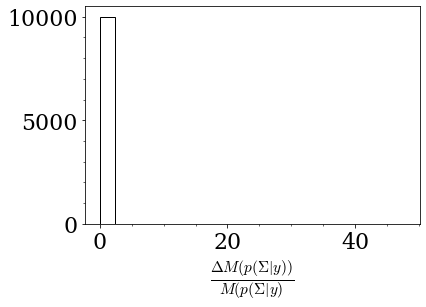

In [19]:
plt.hist(np.abs(diagnostics_df.loc['mcse']/diagnostics_df.loc['sigma_median']),histtype='step',bins=20)
plt.xlabel('$\\frac{\Delta M(p(\Sigma|y))}{M(p(\Sigma|y)}$')
plt.grid(False)
plt.savefig('./plots/toyMC_mcse_hist.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()

In [20]:
pvals=diagnostics_df.loc[[f'pval{i:02d}' for i in range(12)]]
len(pvals.values.ravel())

120000

In [21]:
all_sigmas=[]
for i in range(len(sigma_df.columns)):
    all_sigmas.extend((np.array(sigma_df[f'toybin{i:04d}'].values)-0.3)/np.std(sigma_df[f'toybin{i:04d}'].values))


In [22]:
h=r.TH1D("h","h",100,-5,5)
for i in range(len(all_sigmas)):
    h.Fill(all_sigmas[i])


Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


In [23]:
c=r.TCanvas("c","c")
c.Draw("")
c.SetBottomMargin(0.15)
h.Draw("")
h.GetXaxis().SetLabelFont(132)
h.GetYaxis().SetLabelFont(132)
h.GetYaxis().SetTitle("#font[132]{counts}")
h.GetXaxis().SetTitle("#font[132]{#frac{p(#Sigma|D_{#it{i}})-#Sigma_{true}}{std(p(#Sigma|D_{#it{i}}))}}")
h.SetTitle("")
h.GetYaxis().SetNdivisions(0)
h.GetYaxis().SetLabelSize(0)
r.gStyle.SetOptStat(0)
h.GetXaxis().SetTitleOffset(1.5)
f=r.TF1("f","gaus",-5,5)
h.Fit(f,"S")
t=r.TLatex()
t.SetTextAlign(22)
mu = f.GetParameter(1)
mu_err = f.GetParError(1)
sigma=f.GetParameter(2)
sigma_err=f.GetParError(2)
t.DrawLatex(0,5e3,f"#color[2]{{#font[132]{{#mu={mu:.4f}#pm{mu_err:.4f}, #sigma={sigma:.4f}#pm{sigma_err:.4f}}}}}")

 FCN=432.92 FROM MIGRAD    STATUS=CONVERGED      64 CALLS          65 TOTAL
                     EDM=3.98425e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.14618e+06   2.22838e+02   1.84272e+00   3.89081e-08
   2  Mean        -1.07245e-01   2.20691e-04   2.24466e-06   2.09112e-03
   3  Sigma        1.39225e+00   1.58189e-04   4.41802e-07   2.76716e-01


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


In [24]:
sigma_chi2_df=pd.read_csv('./sigma_chi2.csv',index_col=0).join(pd.read_csv('./sigma_chi2_1.csv',index_col=0))


In [25]:
h1=r.TH1D("h1","h1",25,-5,5)
for i in range(len(sigma_chi2_df.columns)):
    h1.Fill((sigma_chi2_df[f'toybin{i:04d}']['sigma']-0.3)/sigma_chi2_df[f'toybin{i:04d}']['error'])

Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).


In [26]:
c1=r.TCanvas("c1","c")
c1.Draw("")
c1.SetBottomMargin(0.15)
h1.Draw("")
h1.Fit("gaus","S")



 FCN=73.7807 FROM MIGRAD    STATUS=CONVERGED      60 CALLS          61 TOTAL
                     EDM=2.89407e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.38272e+03   1.80258e+01   5.86252e-02  -5.95465e-07
   2  Mean        -7.81613e-02   1.14969e-02   4.85453e-05  -1.96489e-03
   3  Sigma        1.14467e+00   9.52072e-03   8.89506e-06  -2.68454e-03


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [27]:
c.SaveAs("./plots/combined_post_add.pdf")
c.SaveAs("./plots/combined_post_add.root")

Info in <TCanvas::Print>: pdf file ./plots/combined_post_add.pdf has been created
Info in <TCanvas::SaveAs>: ROOT file ./plots/combined_post_add.root has been created


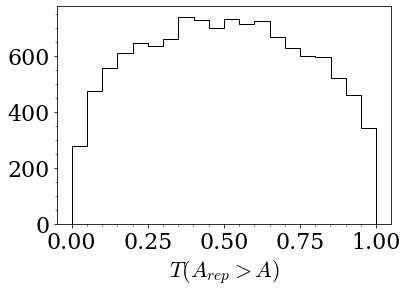

In [28]:
plt.hist(diagnostics_df.loc[[f'pval{i:02d}' for i in range(12)]].values.ravel(),histtype='step',bins=20)
plt.xlabel(r'$T(A_{rep}>A)$')
plt.grid(False)
plt.savefig('./plots/toyMC_pval_hist.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()

In [32]:
h1.GetEntries()

1000.0

In [33]:
h.GetEntries()

4000000.0